In [103]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import statsmodels as sm

In [168]:
class Energy:
    def __init__(self) -> None:
        url = "https://raw.githubusercontent.com/owid/energy-data/master/owid-energy-data.csv"
        req = requests.get(url)
        url_content = req.content
        csv_file = open('./data.csv', 'wb')
        csv_file.write(url_content)
        csv_file.close()
        self.data = pd.read_csv("data.csv")

    def print_data(self):
        return self.data.head()

    def clean_data(self):
        self.data = self.data.fillna(0)
        self.data = self.data[["country", "year", "gdp", "renewables_energy_per_capita", "fossil_energy_per_capita"]].reset_index().drop(["index"], axis=1)
        self.data = self.data[(self.data["year"] >= 1970)&(self.data["year"] <= 2018)]        


    def filter_countries(self, countries:list):
        self.data = self.data.set_index("country").T[countries].T.reset_index()
        try:
            self.data["year"] = pd.DatetimeIndex(pd.to_datetime(self.data["year"], format="%Y")).year
            self.data = self.data.set_index("year")
        except KeyError:
            pass

    def plots(self, type:str, countries:list):
        plt.figure(figsize=(16,8))
        for c in countries:
            if type=="renewables":
                plt.plot(self.data[self.data["country"]==c].renewables_energy_per_capita)
                plt.legend(countries)
            elif type=="fossil":
                plt.plot(self.data[self.data["country"]==c].fossil_energy_per_capita)
                plt.legend(countries)                
            elif type=="gdp":
                plt.plot(self.data[self.data["country"]==c].gdp)
                plt.legend(countries)                
      
    def ols_analysis(self):
        y=self.data["gdp"]
        X=self.data[["fossil_energy_per_capita","renewables_energy_per_capita"]]
        regressor = OLS(y, X).fit()
        print(regressor.summary())



In [169]:
analysis = Energy()

In [170]:
analysis.print_data()
analysis.clean_data()
analysis.print_data()

,country,year,gdp,renewables_energy_per_capita,fossil_energy_per_capita
70,Afghanistan,1970,1.581223e+10,0.0,0.0
71,Afghanistan,1971,1.577051e+10,0.0,0.0
72,Afghanistan,1972,1.317055e+10,0.0,0.0
73,Afghanistan,1973,1.356863e+10,0.0,0.0
74,Afghanistan,1974,1.430911e+10,0.0,0.0


In [171]:
analysis.filter_countries(["Morocco","Portugal","China","India","United States"])

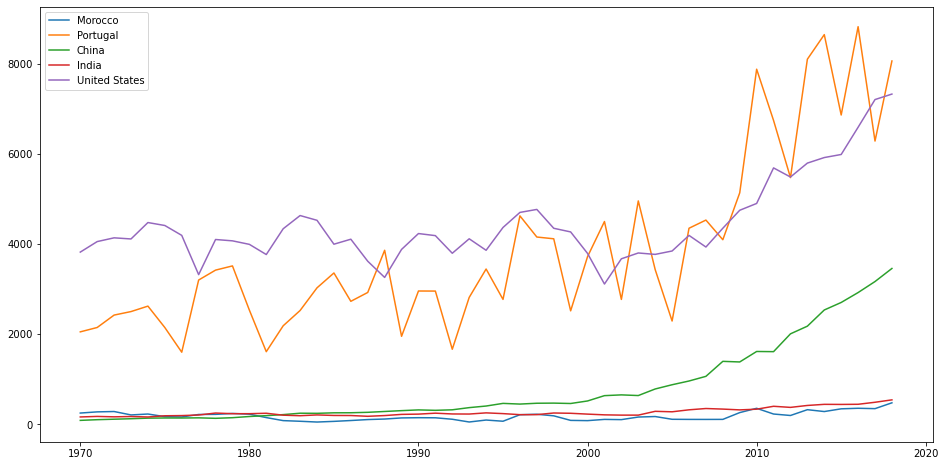

In [172]:
analysis.plots("renewables", countries=["Morocco","Portugal","China","India","United States"])

In [173]:
analysis.ols_analysis()

                                 OLS Regression Results                                
Dep. Variable:                    gdp   R-squared (uncentered):                   0.624
Model:                            OLS   Adj. R-squared (uncentered):              0.621
Method:                 Least Squares   F-statistic:                              201.4
Date:                Sun, 27 Nov 2022   Prob (F-statistic):                    2.64e-52
Time:                        00:23:02   Log-Likelihood:                         -7458.7
No. Observations:                 245   AIC:                                  1.492e+04
Df Residuals:                     243   BIC:                                  1.493e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [223]:
best_consumption = auto_arima(analysis.data[analysis.data["country"]=="India"].fossil_energy_per_capita,
                                      start_p=1,
                                      start_q=1,
                                      max_p=15,
                                      max_q=15,
                                      m=1,
                                      trace=True,
                                      error_action='ignore',
                                      suppress_warnings=True,
                                      stepwise=False
                                      )

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=560.429, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=533.923, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=531.999, Time=0.14 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=530.975, Time=0.19 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=531.462, Time=0.28 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=532.310, Time=0.38 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=528.913, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=528.729, Time=0.17 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=530.592, Time=0.18 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=531.350, Time=0.33 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=533.159, Time=0.44 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=529.056, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=529.999, Time=0.20 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=531.893, Time=0.29 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=529.798, Time=0.44 sec
 ARIMA(3,2,0)(0,0,0)[1]  

c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


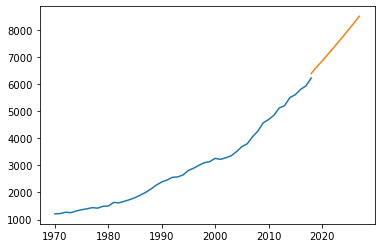

In [233]:
import pmdarima
o = best_consumption.order
model_c = pmdarima.arima.ARIMA(order=o)
pred = model_c.fit_predict(y=analysis.data[analysis.data["country"]=="India"].fossil_energy_per_capita,x=analysis.data[analysis.data["country"]=="India"].index)

plt.plot(analysis.data[analysis.data["country"]=="India"].fossil_energy_per_capita)
plt.plot(pd.Series(pred, index=[t for t in range(2018,2028)]))

In [232]:
pd.Series(pred, index=[t for t in range(2018,2028)])

2018    6399.775371
2019    6642.247904
2020    6850.074765
2021    7083.222039
2022    7308.531254
2023    7544.337511
2024    7780.502347
2025    8022.631863
2026    8267.626145
2027    8517.199302
dtype: float64